# Dataset

source: image with masked-out object

mask: binary mask where object was removed

ref: object crop, resized

target: original full image

Download COCO 2017

In [ ]:
import os
from torchvision.datasets import CocoDetection
from torchvision import transforms
from pycocotools.coco import COCO
import requests, zipfile, io

def download_coco_val(root="coco2017"):
    os.makedirs(root, exist_ok=True)

    url_images = "http://images.cocodataset.org/zips/val2017.zip"
    url_annotations = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"

    # Download val2017 images
    if not os.path.exists(os.path.join(root, "val2017")):
        print("Downloading val2017...")
        r = requests.get(url_images)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(root)

    # Download annotations (contains val annotations too)
    if not os.path.exists(os.path.join(root, "annotations")):
        print("Downloading annotations...")
        r = requests.get(url_annotations)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(root)

    print("✅ COCO val2017 ready at", root)



In [ ]:
download_coco_val()

✅ COCO val2017 ready at coco2017


Create Inpainting Triplets

In [ ]:
def get_valid_mask_and_ref(coco, anns, img_size):
    H, W = img_size
    min_ratio, max_ratio = 0.05, 0.5  # thresholds

    for ann in anns:
        mask = coco.annToMask(ann)
        mask = cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST)
        ratio = mask.sum() / (H * W)
        if min_ratio <= ratio <= max_ratio:  # thresholds
            return mask, ann
    return None, None

In [ ]:
from PIL import Image, ImageDraw
import random
import numpy as np
import torch
import cv2

class CocoInpaintingDataset(torch.utils.data.Dataset):
    def __init__(self, coco_root="coco2017", split="val2017", image_size=256, max_objects=1):
        super().__init__()
        ann_file = os.path.join(coco_root, "annotations", f"instances_{split}.json")
        self.coco = COCO(ann_file)
        self.img_ids = list(self.coco.imgs.keys())
        self.root = os.path.join(coco_root, split)
        self.max_objects = max_objects
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        path = os.path.join(self.root, img_info["file_name"])
        image = Image.open(path).convert("RGB")

        # Load annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        if len(anns) == 0:
            return self[(idx + 1) % len(self)]  # skip empty

        # Pick an object
        # ann = random.choice(anns)
        # mask = self.coco.annToMask(ann)
        mask, ann = get_valid_mask_and_ref(self.coco, anns, image.size[::-1])
        if mask is None:
          # skip image only if ALL annotations invalid
          return self[(idx + 1) % len(self)]

        mask_img = Image.fromarray((mask * 255).astype(np.uint8))

        # Create source (masked image)
        source = image.copy()
        source.paste((0,0,0), mask=mask_img)

        # Create reference (cropped object)
        bbox = ann["bbox"]  # [x,y,w,h]
        x,y,w,h = map(int, bbox)
        ref = image.crop((x,y,x+w,y+h))

        # Target = original image
        target = image

        # Apply transforms
        image = self.transform(image)
        source = self.transform(source)
        ref = self.transform(ref.resize((target.size[0], target.size[1])))  # match size
        mask_tensor = self.transform(mask_img)

        return {
            "source": source,     # masked image
            "mask": mask_tensor,  # binary mask
            "ref": ref,           # reference image
            "target": image       # ground truth
        }


DataLoader

In [ ]:
def get_coco_inpainting_dataloader(root="coco2017", image_size=256, batch_size=8):
    dataset = CocoInpaintingDataset(coco_root=root, split="val2017", image_size=image_size)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)


In [ ]:
dataloader = get_coco_inpainting_dataloader(image_size=256, batch_size=1)

loading annotations into memory...
Done (t=0.47s)
creating index...
index created!


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
batch = next(iter(dataloader))
print(batch["source"].shape)  # (B, 3, 256, 256)
print(batch["mask"].shape)    # (B, 1, 256, 256)
print(batch["ref"].shape)     # (B, 3, 256, 256)
print(batch["target"].shape)  # (B, 3, 256, 256)

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


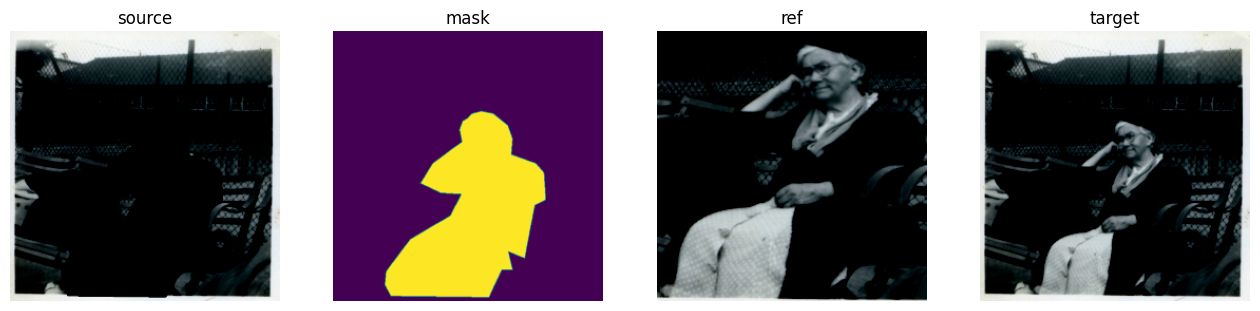

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

for i, (key, tensor) in enumerate(batch.items()):
    img = tensor[0].permute(1, 2, 0).cpu().numpy()  # take first sample, convert to HWC
    axs[i].imshow(img)
    axs[i].set_title(key)
    axs[i].axis("off")

plt.show()


# Code

**Guided inpainting** on top of a pretrained Stable Diffusion Inpainting model, using an extra reference image as guidance (no class/text).

- Start from runwayml/stable-diffusion-inpainting (SD‑1.5 inpaint; UNet has in_channels=9: 4 noisy latents + 4 masked latents + 1 mask).

- Add +4 channels for the reference image latents → new in_channels=13.

- Initialize the new input conv by copying the 9 pretrained channels and zero‑init the extra 4.

- Keep SD’s text pathway fixed to a single null prompt embedding internally so you don’t have to deal with text at all.

In [ ]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW

from diffusers import StableDiffusionInpaintPipeline
from diffusers import AutoencoderKL

In [ ]:
def _expand_unet_in_channels_for_ref(unet, extra_latent_ch=4):
    """
    Expand inpainting UNet input from 9 → 9 + extra_latent_ch.
    Copies the pretrained weights for the original 9 channels,
    zero-inits the new channels.
    """
    old = unet.conv_in
    assert isinstance(old, nn.Conv2d)
    old_in, out_c, k, p, s, d = old.in_channels, old.out_channels, old.kernel_size, old.padding, old.stride, old.dilation
    new_in = old_in + extra_latent_ch
    new = nn.Conv2d(new_in, out_c, kernel_size=k, stride=s, padding=p, dilation=d, bias=old.bias is not None)

    with torch.no_grad():
        new.weight.zero_()
        new.weight[:, :old_in] = old.weight.clone()
        if old.bias is not None:
            new.bias.copy_(old.bias)

    unet.conv_in = new
    # Update config so schedulers/savers know the new channel count
    if hasattr(unet, "config"):
        unet.config.in_channels = new_in
    return unet

In [ ]:
def _prep_latent_mask(mask, latent_h, latent_w, device, dtype):
    """
    mask: (B,1,H,W) in {0,1} where 1==region to be repainted.
    Downsample to latent size, keep single channel.
    """
    mask = F.interpolate(mask, size=(latent_h, latent_w), mode="nearest")
    return mask.to(device=device, dtype=dtype)

In [ ]:
LATENT_SCALE = 0.18215  # SD convention

In [ ]:
def _to_latents(vae, images):
    """
    images in [-1,1], return latents scaled by LATENT_SCALE.
    """
    posterior = vae.encode(images).latent_dist
    z = posterior.sample() * LATENT_SCALE
    return z

In [ ]:
class Unet(nn.Module):
    """
    Guided inpainting model:
      - Loads SD inpainting pipeline
      - Expands UNet to accept reference latents (extra 4 channels)
      - Hides text: uses a fixed 'null' prompt embedding internally
      - forward() predicts noise ε given:
          * noisy image latents
          * masked-image latents
          * mask (latent size, 1ch)
          * reference-image latents
          * timestep t
    """
    def __init__(self, im_channels, model_config):
        super().__init__()

        model_id = "runwayml/stable-diffusion-inpainting"

        device = "cuda" if torch.cuda.is_available() else "cpu"

        torch_dtype = "float16"

        pipe = StableDiffusionInpaintPipeline.from_pretrained(
            model_id, torch_dtype=torch_dtype, safety_checker=None, feature_extractor=None
        ).to(device)

        # Expand UNet to accept +4 ref-latent channels (9 → 13)
        _expand_unet_in_channels_for_ref(pipe.unet, extra_latent_ch=4)

        # Prepare a fixed null-text embedding
        with torch.no_grad():
            prompt = [""]  # single null prompt
            text_inputs = pipe.tokenizer(
                prompt,
                padding="max_length",
                max_length=pipe.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            null_emb = pipe.text_encoder(**text_inputs)[0]  # (1,77,768)
            self.register_buffer("null_prompt_embeds", null_emb, persistent=False)

        self.pipe = pipe
        self.unet = pipe.unet
        self.vae = pipe.vae
        self.scheduler = pipe.scheduler
        self.device = device
        self.dtype = torch_dtype

    @torch.no_grad()
    def encode_images_to_latents(self, images):
        """
        images: (B,3,H,W) in [-1,1]
        returns latents: (B,4,h,w)
        """
        return _to_latents(self.vae, images.to(self.device, dtype=self.vae.dtype))

    @torch.no_grad()
    def decode_latents_to_images(self, latents):
        """
        latents: (B,4,h,w), returns images in [-1,1]
        """
        latents = latents.to(self.device, dtype=self.vae.dtype) / LATENT_SCALE
        return self.vae.decode(latents).sample

    # Prep mask to latent size
    def prepare_mask(self, mask, latent_h, latent_w):
        return _prep_latent_mask(mask, latent_h, latent_w, self.device, self.unet.dtype)

    # Noise Prediction
    def forward(
        self,
        noisy_latents,            # (B,4,h,w)
        t,                        # (B,) or scalar timestep
        masked_image_latents,     # (B,4,h,w)
        mask_latent,              # (B,1,h,w) in {0,1}
        ref_latents,              # (B,4,h,w)
    ):
        """
        Returns ε prediction with no text conditioning (fixed null embed).
        UNet input is concatenation along channel dim:
            [ noisy_latents, masked_image_latents, mask_latent, ref_latents ]  -> (B, 13, h, w)
        """
        # Build model input like SD inpainting + ref latents
        latent_model_input = torch.cat([noisy_latents, masked_image_latents, mask_latent, ref_latents], dim=1)

        noise_pred = self.unet(
            latent_model_input,
            t,
            encoder_hidden_states=self.null_prompt_embeds.expand(latent_model_input.shape[0], -1, -1),
        ).sample
        return noise_pred


In [ ]:
# Pseudocode for the trainer loop (not the full file)
model = Unet(im_channels=3, model_config={"pretrained_model_name_or_path": "runwayml/stable-diffusion-inpainting"})
scheduler = model.scheduler  # DDPMScheduler already configured from the pipeline

# Freeze VAE & text encoder (we don't train them)
for p in model.vae.parameters():
    p.requires_grad = False
if hasattr(model, "pipe") and hasattr(model.pipe, "text_encoder"):
    for p in model.pipe.text_encoder.parameters():
        p.requires_grad = False

# Optimizer: train the UNet (including the new conv_in channels we added)
optimizer = AdamW(
    model.unet.parameters(),
    lr=1e-4,              # tweak as needed
    betas=(0.9, 0.999),
    weight_decay=1e-2,
    eps=1e-8,
)

model.unet.to(model.device, dtype=torch.float32)
model.vae.to(model.device, dtype=torch.float32)
model.unet.enable_gradient_checkpointing()

Passed `torch_dtype` torch.float32 is not a `torch.dtype`. Defaulting to `torch.float32`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelin

In [ ]:
model.unet.train()

scaler = torch.cuda.amp.GradScaler()
for batch in dataloader:
    images = batch["target"].to(model.device)      # original ground-truth
    ref_images = batch["ref"].to(model.device)     # reference object
    masks = batch["mask"].to(model.device)         # binary mask (B,1,H,W)
    source_images = batch["source"].to(model.device)  # masked input

    # Encode to latents
    with torch.no_grad():
        latents = model.encode_images_to_latents(images)            # (B,4,h,w)
        ref_latents = model.encode_images_to_latents(ref_images)    # (B,4,h,w)

        masked_image_latents = model.encode_images_to_latents(source_images)  # (B,4,h,w)

        # Downsample mask to latent size
        _, _, h, w = latents.shape
        mask_latent = F.interpolate(masks, size=(h, w), mode="nearest").to(dtype=latents.dtype)

    # Noise + timestep
    noise = torch.randn_like(latents)
    timesteps = torch.randint(
        0, scheduler.num_train_timesteps,
        (latents.size(0),), device=latents.device
    ).long()
    noisy_latents = scheduler.add_noise(latents, noise, timesteps)

    # Ensure everything is on the same device & dtype
    noisy_latents = noisy_latents.to(model.device, dtype=model.unet.dtype)
    timesteps = timesteps.to(model.device)
    masked_image_latents = masked_image_latents.to(model.device, dtype=model.unet.dtype)
    mask_latent = mask_latent.to(model.device, dtype=model.unet.dtype)
    ref_latents = ref_latents.to(model.device, dtype=model.unet.dtype)

    with torch.autocast(device_type="cuda", dtype=torch.float16):
      # Predict ε
      noise_pred = model(
          noisy_latents=noisy_latents,
          t=timesteps,
          masked_image_latents=masked_image_latents,
          mask_latent=mask_latent,
          ref_latents=ref_latents,
      )

      # Loss + backprop
      loss = F.mse_loss(noise_pred, noise)

    optimizer.zero_grad(set_to_none=True)
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()


/tmp/ipython-input-171135578.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("di

OutOfMemoryError: CUDA out of memory. Tried to allocate 58.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 12251 has 14.74 GiB memory in use. Of the allocated memory 14.40 GiB is allocated by PyTorch, and 199.55 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
print("UNet device:", next(model.unet.parameters()).device)
print("UNet dtype:", next(model.unet.parameters()).dtype)

print("noisy_latents:", noisy_latents.device, noisy_latents.dtype)
print("masked_image_latents:", masked_image_latents.device, masked_image_latents.dtype)
print("mask_latent:", mask_latent.device, mask_latent.dtype)
print("ref_latents:", ref_latents.device, ref_latents.dtype)
